In [26]:
import numpy as np
import pandas as pd 
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
print(os.listdir("C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats"))


['dogscats', 'sample', 'test1', 'train', 'valid']


In [4]:
!pip install keras

In [9]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [10]:
filenames = os.listdir("C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [11]:
df.head()


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [12]:
df.tail()


,filename,category
22995,dog.9995.jpg,1
22996,dog.9996.jpg,1
22997,dog.9997.jpg,1
22998,dog.9998.jpg,1
22999,dog.9999.jpg,1


<AxesSubplot:>

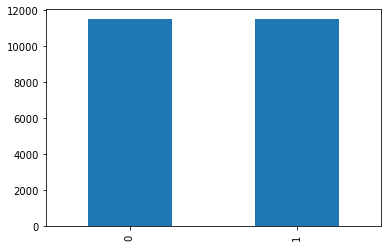

In [13]:
df['category'].value_counts().plot.bar()


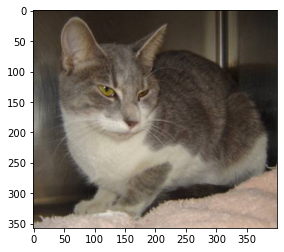

In [14]:
sample = random.choice(filenames)
image = load_img("C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/train/"+sample)
plt.imshow(image)

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [17]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
callbacks = [earlystop, learning_rate_reduction]


In [19]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 


In [20]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<AxesSubplot:>

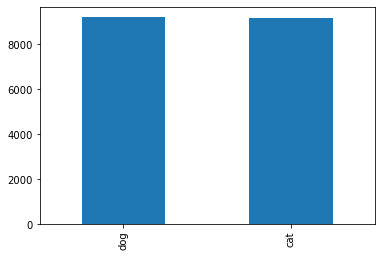

In [21]:
train_df['category'].value_counts().plot.bar()


<AxesSubplot:>

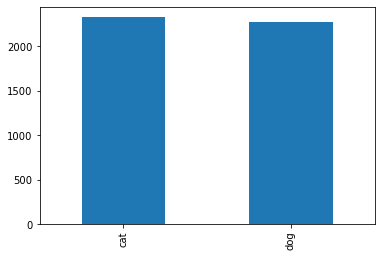

In [22]:
validate_df['category'].value_counts().plot.bar()


In [23]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [27]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [28]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 18400 validated image filenames belonging to 2 classes.


In [30]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 4600 validated image filenames belonging to 2 classes.


In [31]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


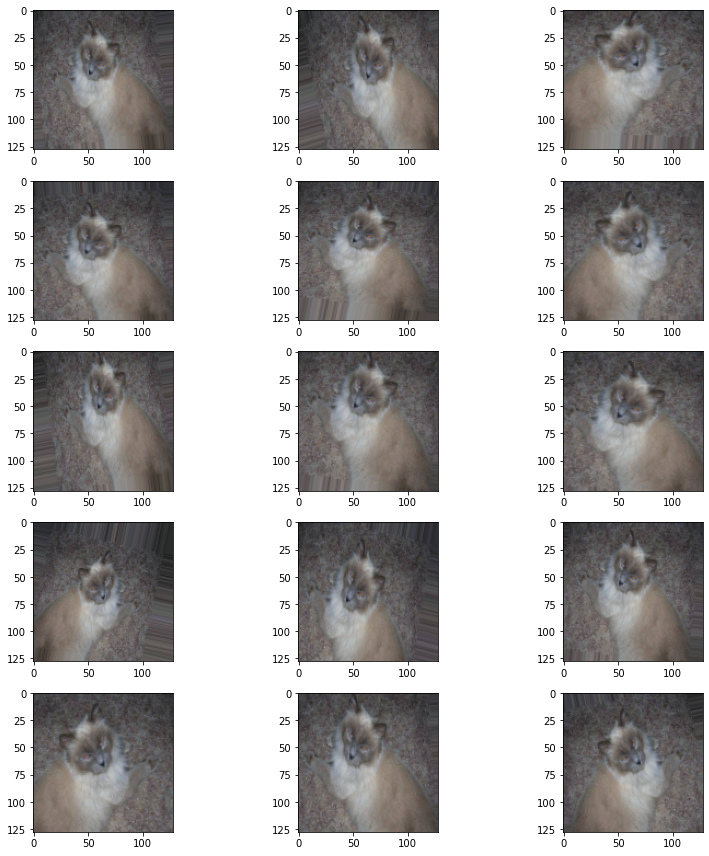

In [40]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [34]:
epochs=3 if FAST_RUN else 5
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/5


C:\Users\ASUS ZenBook\AppData\Local\Temp\ipykernel_13376\1352027716.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


1226/1226 [==============================] - 1037s 846ms/step - loss: 0.5938 - accuracy: 0.6947 - val_loss: 0.5209 - val_accuracy: 0.7442 - lr: 0.0010
Epoch 2/5
1226/1226 [==============================] - 1356s 1s/step - loss: 0.5346 - accuracy: 0.7414 - val_loss: 0.6550 - val_accuracy: 0.7072 - lr: 0.0010
Epoch 3/5
1226/1226 [==============================] - 1180s 962ms/step - loss: 0.4896 - accuracy: 0.7689 - val_loss: 0.5533 - val_accuracy: 0.7551 - lr: 0.0010
Epoch 4/5
1226/1226 [==============================] - 1075s 877ms/step - loss: 0.4688 - accuracy: 0.7812 - val_loss: 0.4699 - val_accuracy: 0.8011 - lr: 0.0010
Epoch 5/5
1226/1226 [==============================] - 1080s 881ms/step - loss: 0.4374 - accuracy: 0.8018 - val_loss: 0.3697 - val_accuracy: 0.8368 - lr: 0.0010


In [35]:
model.save_weights("model.h5")


NameError: name 'model' is not defined

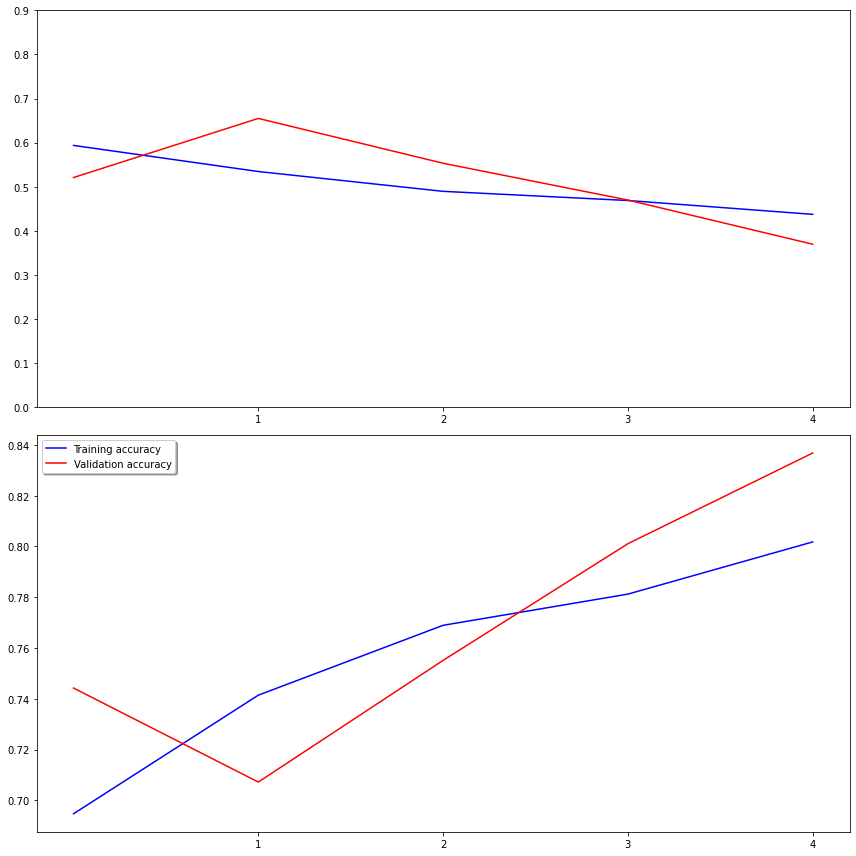

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [47]:
test_filenames = os.listdir("C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [50]:
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [51]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

C:\Users\ASUS ZenBook\AppData\Local\Temp\ipykernel_13376\3090721588.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [52]:
test_df['category'] = np.argmax(predict, axis=-1)

In [57]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

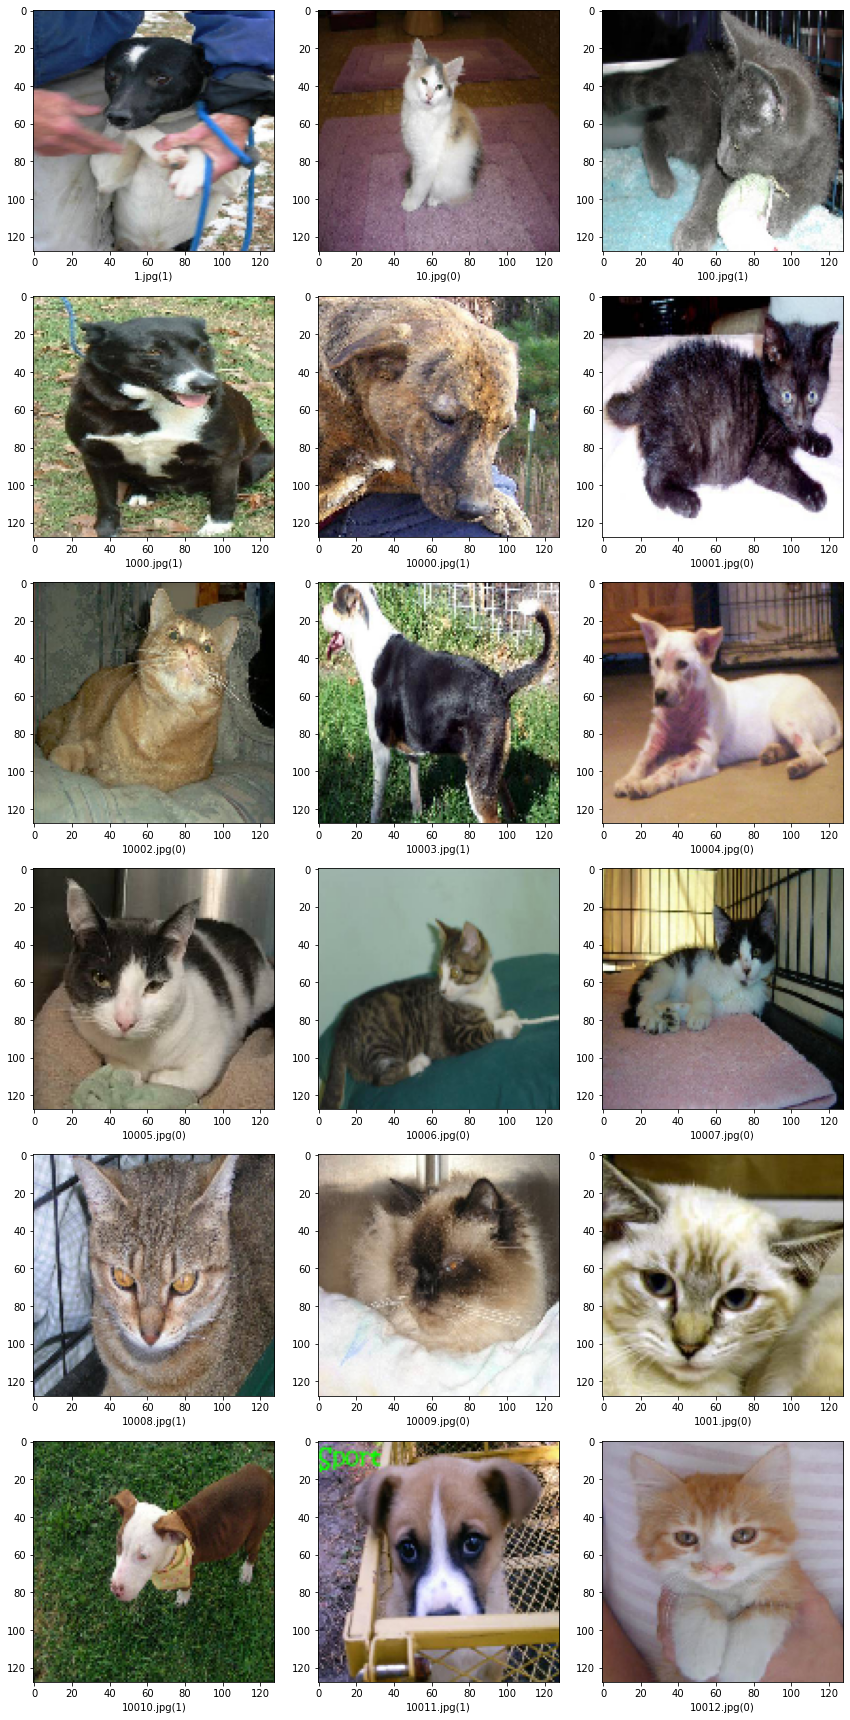

In [59]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("C:/Users/ASUS ZenBook/Pictures/UPEC_IA/archive/dogscats/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [78]:
results={
    0:'cat',
    1:'dog'
}
from PIL import Image
import numpy as np
im=Image.open("C:/Users/ASUS ZenBook/Documents/archive/puppy.jpg") # image a prédire
im=im.resize(IMAGE_SIZE)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]
s=pred[0]
i=0
for p in pred:
    if (p>s):
        i=i+1
        s=p
print(results[i])


1/1 [==============================] - 0s 63ms/step
dog


In [79]:
# CHANGER QUELQUES PARAMETRES (FONCTION ACTIVATION, LR = 0,01) et voir les accuracies et les loss

In [41]:
from keras.models import Sequential
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='selu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='selu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), activation='selu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512, activation='selu'))
model.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='sigmoid')) # 2 because we have cat and dog classes
opt = keras.optimizers.Adam(learning_rate=0.01)  #learning rate a 0,01

model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 61, 61, 64)      

In [42]:
epochs=3 if FAST_RUN else 8
history2 = model2.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/8


C:\Users\ASUS ZenBook\AppData\Local\Temp\ipykernel_13376\2016724532.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(


1226/1226 [==============================] - 1445s 1s/step - loss: 8.0913 - accuracy: 0.5051 - val_loss: 0.7214 - val_accuracy: 0.5007
Epoch 2/8
1226/1226 [==============================] - 1753s 1s/step - loss: 0.9891 - accuracy: 0.5038 - val_loss: 0.7060 - val_accuracy: 0.4943
Epoch 3/8
1226/1226 [==============================] - 1459s 1s/step - loss: 1.1654 - accuracy: 0.4969 - val_loss: 1.5661 - val_accuracy: 0.5063
Epoch 4/8
1226/1226 [==============================] - 1253s 1s/step - loss: 1.4341 - accuracy: 0.4982 - val_loss: 0.8163 - val_accuracy: 0.5059
Epoch 5/8
1226/1226 [==============================] - 1310s 1s/step - loss: 1.6054 - accuracy: 0.4967 - val_loss: 1.0462 - val_accuracy: 0.5061
Epoch 6/8
1226/1226 [==============================] - 1365s 1s/step - loss: 1.5739 - accuracy: 0.4983 - val_loss: 0.9731 - val_accuracy: 0.4948
Epoch 7/8
1226/1226 [==============================] - 1237s 1s/step - loss: 1.6821 - accuracy: 0.4985 - val_loss: 0.7413 - val_accuracy: 0.

In [43]:
model.save_weights("model_SELU_001LR.h5")


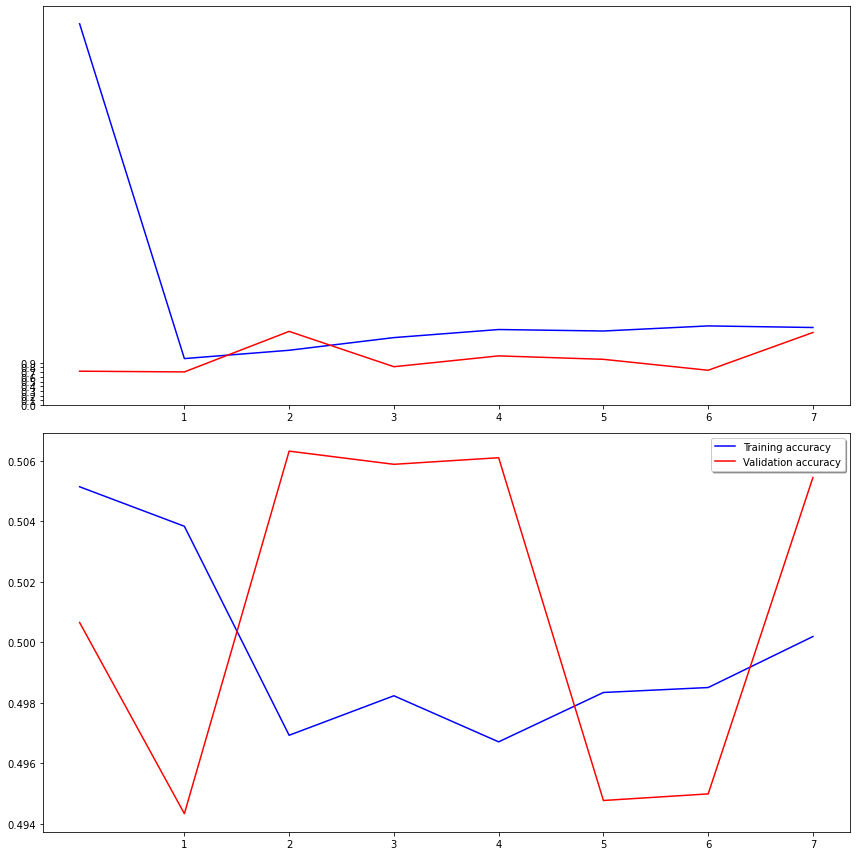

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history2.history['loss'], color='b', label="Training loss")
ax1.plot(history2.history['val_loss'], color='r', label="validation loss")

ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()